# E-Commerce Transactions Analysis

This project analyzes a UK-based online retail dataset containing all transactions from **December 2010 to December 2011**.  
The company primarily sells unique all-occasion gifts, with many customers being wholesalers.  

The goal is to explore, clean, and analyze the data to uncover meaningful insights about customers, products, and sales trends.  
This notebook is structured as a series of **business-driven questions** to demonstrate a full data analyst workflow.

---

## 1. Data Quality and Preparation
- How many transactions are missing `CustomerID`?  
- Are there negative or zero values in `Quantity` or `UnitPrice` that may indicate returns or errors?  
- What is the overall completeness and consistency of the dataset?  

---

## 2. Sales Overview
- What is the total number of transactions and items sold?  
- What are the top 10 products by quantity sold?  
- What are the top 10 products by revenue (`Quantity * UnitPrice`)?  
- Which countries generate the most transactions and revenue?  

---

## 3. Customer Analysis
- How many unique customers are in the dataset?  
- Who are the top customers by revenue?  
- How is revenue distributed across customers (do a few drive most of the sales)?  
- What proportion of total revenue comes from the top 5% of customers?  

---

## 4. Time Trends
- How do sales evolve month by month?  
- What are the peak months, days, or hours for transactions?  
- Are there noticeable seasonal or holiday patterns?  

---

## 5. Business Insights
- Which countries have the highest average order value (AOV)?  
- Who are the most frequent/repeat customers?  
- What is the return rate (negative quantities) overall and by customer/product?  
- Are there potential outliers in prices or quantities that may distort analysis?  

---

## 6. Advanced Customer Insights
- Can we build an **RFM segmentation** (Recency, Frequency, Monetary) to profile customers?  
- What actionable recommendations can be drawn for marketing, operations, or product strategy based on this analysis?  


---

## 7. Customer Retention and Lifetime Value (LTV)
- How many customers make repeat purchases?  
- How does new customer acquisition change over time?  
- What is the retention rate by monthly cohort (based on first purchase)?  
- How does average LTV vary across cohorts or countries?  
- What patterns suggest churn or seasonal effects?  

---

## 8. Conclusion
Summarize the key insights, highlight potential business implications, and suggest next steps for further analysis or decision-making.



In [ ]:
##Importing packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandera as pa
from pandera import Check, Column
import os

In [ ]:
##Importing dataset
dataset_name = os.getenv('sample_dataset','./ecommerce.csv' )
df = pd.read_csv(dataset_name, encoding='latin1', encoding_errors='replace')


UTF-8 enconding fails, probably due to pounds symbol. Encoding in latin1 instead to prevent error.


In [3]:
##First glimse of the dataset
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


# 1) Data Quality and preparation

In [4]:
##How many transactions are missing CustomerID?
tx_missing_customerid = df.CustomerID.isna().sum()
print(f'There are {tx_missing_customerid} missing customer id in the total {df.CustomerID.shape[0]} transactions, that is 25%')


There are 135080 missing customer id in the total 541909 transactions, that is 25%


In [5]:
#Are there negative or zero values in `Quantity` or `UnitPrice` that may indicate returns or errors?
negative_quantity_amount = df.Quantity.le(0).sum()
negative_unitprice_amount = df.UnitPrice.le(0).sum()
print(f'There are {negative_quantity_amount} negative quantities listed, and {negative_unitprice_amount} negative unit prices listed. This may indicate returns or errors')

There are 10624 negative quantities listed, and 2517 negative unit prices listed. This may indicate returns or errors


In [6]:
##What is the overall completeness and consistency of the dataset? 
list_of_na = df.isna().sum()
clean_list_of_na = list_of_na[list_of_na.ne(0)]
print('The following fields have empty values')
print(clean_list_of_na)


The following fields have empty values
Description      1454
CustomerID     135080
dtype: int64


In [7]:
##Checking for duplicated rows
dups_amount = df.duplicated().sum()
print(f'There is {dups_amount} duplicated rows')

There is 5268 duplicated rows


We found many duplicated rows with exact date and invoice number. This should be cleaned:

In [8]:
df = df.drop_duplicates()

Checking the health of columns in general for inconsistencies.

In [9]:
df.Country.unique() #Correct, no rare countries
df.CustomerID.lt(0).sum() #Correct, non negative customerID
df.InvoiceDate.max() #Correct, dates in range
df.InvoiceDate.min() #Correct, dates in range
df.Quantity[df.Quantity.lt(0)].unique() # Quantity of -80995 observed. It seems to be correct, undoing another transaction of +80995 from same CustomerID
df[df.Quantity == -80995] #Auxiliary to former check
df[df.CustomerID == 16446.0] #Auxiliary to former check


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
194354,553573,22980,PANTRY SCRUBBING BRUSH,1,5/18/2011 9:52,1.65,16446.0,United Kingdom
194355,553573,22982,PANTRY PASTRY BRUSH,1,5/18/2011 9:52,1.25,16446.0,United Kingdom
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,12/9/2011 9:15,2.08,16446.0,United Kingdom
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,12/9/2011 9:27,2.08,16446.0,United Kingdom


In [10]:
df.InvoiceDate = pd.to_datetime(df.InvoiceDate) #Turning date String into Datetime format for good handling

All previous check passed successfully. Health of the information is acceptable.

In [11]:
#Simple final schema validation with Pandera to detect errors in resulting schema.
schema = pa.DataFrameSchema(
        {
            "InvoiceNo": Column(str, Check.str_matches(r"^[A-Za-z0-9]+$")),
            "StockCode": Column(str, Check.str_length(min_value=1)),
            "Description": Column(str, Check.str_length(min_value=1), nullable=True),
            "Quantity": Column(int),
            "InvoiceDate": Column(pa.DateTime),
            "UnitPrice": Column(float),
            "Country": Column(str, Check.str_length(min_value=1)),
        },
        coerce=True,
        strict="filter",
    )
schema.validate(df, lazy=True)

C:\Users\device\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandera\_pandas_deprecated.py:149: FutureWarning: Importing pandas-specific classes and functions from the
top-level pandera module will be **removed in a future version of pandera**.
If you're using pandera to validate pandas objects, we highly recommend updating
your import:

```
# old import
import pandera as pa

# new import
import pandera.pandas as pa
```

If you're using pandera to validate objects from other compatible libraries
like pyspark or polars, see the supported libraries section of the documentation
for more information on how to import pandera:

https://pandera.readthedocs.io/en/stable/supported_libraries.html

To disable this warning, set the environment variable:

```
export DISABLE_PANDERA_IMPORT_WARNING=True
```

  warnings.warn(_future_warning, FutureWarning)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,United Kingdom
...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,France


# 2) Sales overview

In [12]:
# What is the total number of transactions and items sold?  
amount_tx = df.InvoiceNo.nunique()
items_sold = df.Quantity.sum()
print(f'The amount of transactions is {amount_tx} and the amount if items sold is {items_sold}')

The amount of transactions is 25900 and the amount if items sold is 5162502


In [13]:
# What are the top 10 products by quantity sold? 
ten_items_most_sold_stockcode = df.groupby(['StockCode', 'Description'])['Quantity'].sum().sort_values(ascending=False).head(10).reset_index()
ten_items_most_sold_stockcode 

,StockCode,Description,Quantity
0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,53751
1,85099B,JUMBO BAG RED RETROSPOT,47260
2,22197,POPCORN HOLDER,36322
3,84879,ASSORTED COLOUR BIRD ORNAMENT,36282
4,21212,PACK OF 72 RETROSPOT CAKE CASES,36016
5,85123A,WHITE HANGING HEART T-LIGHT HOLDER,35006
6,23084,RABBIT NIGHT LIGHT,30631
7,22492,MINI PAINT SET VINTAGE,26437
8,22616,PACK OF 12 LONDON TISSUES,26299
9,21977,PACK OF 60 PINK PAISLEY CAKE CASES,24719


The list of the top 10 items most sold (counting returned items) is the list above.

In [14]:
#What are the top 10 products by revenue (Quantity * UnitPrice)?
df['Revenue'] = df.Quantity * df.UnitPrice
ten_items_most_revenue = df.groupby(['StockCode', 'Description'])['Revenue'].sum().sort_values(ascending=False).head(10).reset_index()
ten_items_most_revenue

,StockCode,Description,Revenue
0,DOT,DOTCOM POSTAGE,206245.48
1,22423,REGENCY CAKESTAND 3 TIER,164459.49
2,47566,PARTY BUNTING,98243.88
3,85123A,WHITE HANGING HEART T-LIGHT HOLDER,97659.94
4,85099B,JUMBO BAG RED RETROSPOT,92175.79
5,23084,RABBIT NIGHT LIGHT,66661.63
6,POST,POSTAGE,66230.64
7,22086,PAPER CHAIN KIT 50'S CHRISTMAS,63715.24
8,84879,ASSORTED COLOUR BIRD ORNAMENT,58792.42
9,79321,CHILLI LIGHTS,53746.66


The previous list shows the top ten items ordered by total revenue.

In [15]:
#Which countries generate the most transactions and revenue?
countries_by_tx = df.groupby('Country')['InvoiceNo'].nunique().sort_values(ascending=False).head(10)
countries_by_tx

Country
United Kingdom    23494
Germany             603
France              461
EIRE                360
Belgium             119
Spain               105
Netherlands         101
Switzerland          74
Portugal             71
Australia            69
Name: InvoiceNo, dtype: int64

Countries by amount of transactions is displayed in the table above

In [16]:
countries_by_revenue = df.groupby('Country')['Revenue'].sum().sort_values(ascending=False).head(10)
countries_by_revenue


Country
United Kingdom    8167128.184
Netherlands        284661.540
EIRE               262993.380
Germany            221509.470
France             197317.110
Australia          137009.770
Switzerland         56363.050
Spain               54756.030
Belgium             40910.960
Sweden              36585.410
Name: Revenue, dtype: float64

In [17]:
print('In percentage this is:')
countries_by_revenue/df.Revenue.sum()*100

In percentage this is:


Country
United Kingdom    83.972058
Netherlands        2.926808
EIRE               2.704022
Germany            2.277497
France             2.028758
Australia          1.408695
Switzerland        0.579509
Spain              0.562986
Belgium            0.420635
Sweden             0.376161
Name: Revenue, dtype: float64

Countries by amount of revenue is displayed in the table above

# 3) Customer Analysis

In [18]:
#How many unique customers are in the dataset?  
unique_customers = df.CustomerID.nunique()
print(f'There are {unique_customers} amount of unique customers')

There are 4372 amount of unique customers


In [19]:
#Who are the top customers by revenue? 
customers_revenue = df.groupby('CustomerID')['Revenue'].sum().sort_values(ascending=False)
print('Here are the top 10 customers by revenue')
customers_revenue.head(10)

Here are the top 10 customers by revenue


CustomerID
14646.0    279489.02
18102.0    256438.49
17450.0    187322.17
14911.0    132458.73
12415.0    123725.45
14156.0    113214.59
17511.0     88125.38
16684.0     65892.08
13694.0     62690.54
15311.0     59284.19
Name: Revenue, dtype: float64

In [20]:
#- How is revenue distributed across customers (do a few drive most of the sales)?  
customer_revenue_percentual = customers_revenue*100/df.Revenue.sum()
print('These are the customer revenue in percentage of the total revenue')
customer_revenue_percentual.head(10).round(2)

These are the customer revenue in percentage of the total revenue


CustomerID
14646.0    2.87
18102.0    2.64
17450.0    1.93
14911.0    1.36
12415.0    1.27
14156.0    1.16
17511.0    0.91
16684.0    0.68
13694.0    0.64
15311.0    0.61
Name: Revenue, dtype: float64

In [21]:
#What proportion of total revenue comes from the top 5% of customers? 
nr_5percent_customers = int(df.CustomerID.nunique()*0.05)
revenue_5percent_customers = customers_revenue.head(nr_5percent_customers).sum()
percentage_revenue_5percent_customers = revenue_5percent_customers/df.Revenue.sum()*100
print(f'The top 5% of customers, corresponding to {nr_5percent_customers} customers, account for {percentage_revenue_5percent_customers.round(1)}% of the total revenue')

The top 5% of customers, corresponding to 218 customers, account for 41.4% of the total revenue


# 4) Time Trends

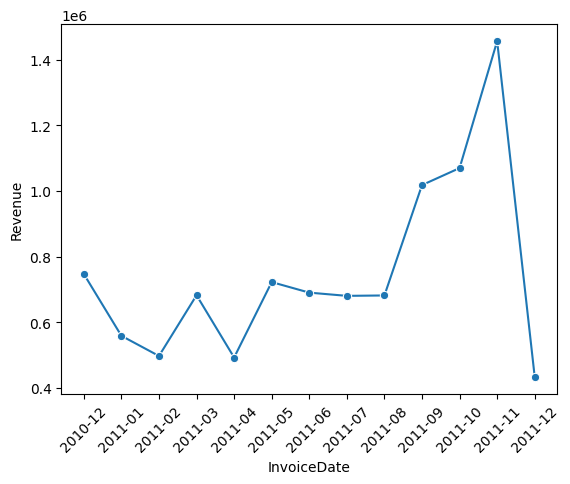

In [22]:
#How do sales evolve month by month? 
X = df.InvoiceDate.dt.to_period('M').astype(str) #year-month dates, but strings so seaborn can plot

ds = df.groupby(X)['Revenue'].sum().reset_index() # New dataframe from grouped revenue by date

sns.lineplot(data=ds, x='InvoiceDate', y='Revenue', marker="o")
plt.xticks(rotation=45);

We observe above the revenue vs date graph. 
For the last month, 2011-12, there's a big drop in revenue that must be explored.

In [23]:
max_date = df.InvoiceDate.max()
print(f'The last day registered is {max_date}, so most of the month is not registered')

The last day registered is 2011-12-09 12:50:00, so most of the month is not registered


Text(0.5, 1.0, 'Revenue by date, only for the first 9 days of the month')

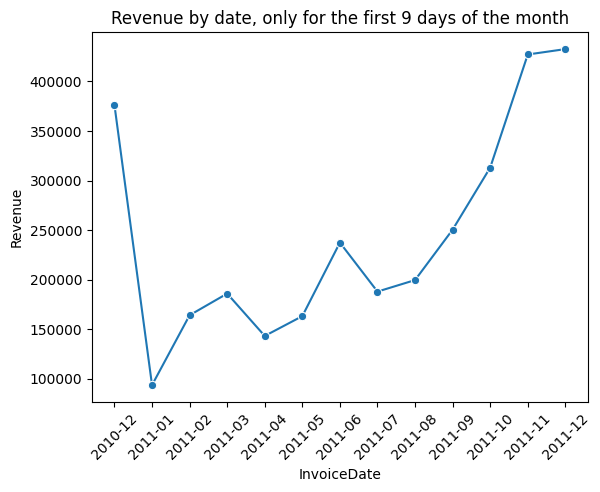

In [24]:
#We will compare the first 9 days of all months to see if the explanation is all there is to the small total revenue on that month
dw = df[df['InvoiceDate'].dt.day.le(9)]
ds = dw.groupby(X)['Revenue'].sum().reset_index() # New dataframe from grouped revenue by date

sns.lineplot(data=ds, x='InvoiceDate', y='Revenue', marker="o")
plt.xticks(rotation=45);
plt.title('Revenue by date, only for the first 9 days of the month')

The last graph confirms that December's first 9 days are better than any other month, so the first's graph low revenue on December is explained by the 9 day window only.

In [25]:
#What are the peak months, days, or hours for transactions?
best_months = df.groupby(df.InvoiceDate.dt.to_period('M'))['Revenue'].sum().sort_values(ascending=False)
best_days = df.groupby(df.InvoiceDate.dt.to_period('D'))['Revenue'].sum().sort_values(ascending=False)
best_hour = df.groupby(df.InvoiceDate.dt.to_period('h'))['Revenue'].sum().sort_values(ascending=False)

print(f'The best months in terms of revenue are \n{best_months.head(15)}, \n\nBest days is \n{best_days.head(15)} \n\nBest hour \n{best_hour.head(15)}')

The best months in terms of revenue are 
InvoiceDate
2011-11    1456145.800
2011-10    1069368.230
2011-09    1017596.682
2010-12     746723.610
2011-05     722094.100
2011-06     689977.230
2011-03     682013.980
2011-08     681386.460
2011-07     680156.991
2011-01     558448.560
2011-02     497026.410
2011-04     492367.841
2011-12     432701.060
Freq: M, Name: Revenue, dtype: float64, 

Best days is 
InvoiceDate
2011-11-14    111958.62
2011-09-20    109228.08
2011-12-08     81294.33
2011-11-23     78223.52
2011-10-05     75111.57
2011-12-07     74952.61
2011-08-11     72071.89
2011-11-29     72008.09
2011-03-29     70531.47
2011-11-07     69824.57
2011-11-10     68815.98
2011-01-11     67792.08
2011-11-16     64123.06
2011-10-03     64081.90
2011-10-21     62920.76
Freq: D, Name: Revenue, dtype: float64 

Best hour 
InvoiceDate
2011-11-07 17:00    54089.63
2011-11-14 17:00    51884.23
2011-09-20 10:00    38431.25
2011-09-15 15:00    38162.96
2010-12-21 15:00    37870.98
2011-09-20 

In [26]:
#- Are there noticeable seasonal or holiday patterns?  


It's not possible to give much advise on patterns only having one year to analyze, but it seems September, October and November are higher than the rest of the year in terms of revenue. This is seen in the first graph in this section (Time Trends)

# 5) Business Insights

In [27]:
# Which countries have the highest average order value (AOV)?  
# (metric that measures the average amount of money a customer spends on each order)
avg_country_invoice_revenue = (df.groupby('Country')['Revenue'].sum()/df.groupby('Country')['InvoiceNo'].nunique()).sort_values(ascending=False)

print('Above is the top 5 countries by average invoice revenue')
avg_country_invoice_revenue.head(5)

Above is the top 5 countries by average invoice revenue


Country
Netherlands    2818.431089
Australia      1985.648841
Lebanon        1693.880000
Japan          1262.165000
Brazil         1143.600000
dtype: float64

In [28]:
#- Who are the most frequent/repeat customers?  
n_buys = df.groupby('CustomerID')['InvoiceNo'].nunique().sort_values(ascending=False).head(5)
n_items = df.groupby('CustomerID').size().sort_values(ascending=False).head(5)

print(f'The top 5 clients by amount of purchases is \n{n_buys} \n\nand by amount of products purchased {n_items}')

The top 5 clients by amount of purchases is 
CustomerID
14911.0    248
12748.0    224
17841.0    169
14606.0    128
15311.0    118
Name: InvoiceNo, dtype: int64 

and by amount of products purchased CustomerID
17841.0    7812
14911.0    5898
14096.0    5128
12748.0    4459
14606.0    2759
dtype: int64


In [29]:
#What is the return rate (negative quantities) overall and by customer/product?  
##We will define the return_rate as amount of items returned over the amount of items purchased
df_negative_quantities = df[(df['Quantity']<0)&(~df['CustomerID'].isin(['15823','16742']))]
df_positive_quantities = df[(df['Quantity']>0)&(~df['CustomerID'].isin(['15823','16742']))]
returned = df_negative_quantities['Quantity'].sum()
bought = df_positive_quantities['Quantity'].sum()
return_rate = 100*abs(returned)/bought
print(f'=>We discovered that Customers 15823.0 and 16742.0 have errors in their invoices, so we filter them out. More on this later') 
print(f'Overall return rate {round(return_rate,1)}%')

=>We discovered that Customers 15823.0 and 16742.0 have errors in their invoices, so we filter them out. More on this later
Overall return rate 8.5%


In [30]:
return_by_customer = df_negative_quantities.groupby('CustomerID')['Quantity'].sum().sort_values()
purchased_by_customer = df_positive_quantities.groupby('CustomerID')['Quantity'].sum().sort_values(ascending=False)
return_rate_by_customer = (abs(return_by_customer)/purchased_by_customer).sort_values(ascending=False)
return_rate_by_customer.head(5)


CustomerID
15823.0    284.000000
16742.0    190.000000
17548.0      3.275862
15802.0      2.000000
16546.0      1.551913
Name: Quantity, dtype: float64

Customers 15823.0 and 16742.0 show return rates higher than 100%. Let's explore this further. We know some transactions have no CustomerID and this could be the reason.

In [31]:
df[df.CustomerID.eq(15823)] 
#We confirm only one positive amount from invoice 536779 and all the other transactions are negative from the same invoice C540307
df[df.CustomerID.eq(16742)]
#Similar case. The positive value is from "Manual" stockcode, the rest all come from the same invoice C572410


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
414248,C572410,23174,REGENCY SUGAR BOWL GREEN,-2,2011-10-24 11:58:00,3.75,16742.0,United Kingdom,-7.5
414249,C572410,22699,ROSES REGENCY TEACUP AND SAUCER,-168,2011-10-24 11:58:00,2.55,16742.0,United Kingdom,-428.4
414250,C572410,23170,REGENCY TEA PLATE ROSES,-20,2011-10-24 11:58:00,1.45,16742.0,United Kingdom,-29.0
414251,572423,M,Manual,1,2011-10-24 12:02:00,464.90,16742.0,United Kingdom,464.9


The most reasonable explanation is missing invoices or invoices without the linked CustomerID.
We will remove these customers from the provided list of return rates as they are incorrect (information is missing)

In [32]:
print('The corrected top 5 highest return rate by customer is the following')
return_rate_by_customer[return_rate_by_customer<100].head(7)

The corrected top 5 highest return rate by customer is the following


CustomerID
17548.0    3.275862
15802.0    2.000000
16546.0    1.551913
17603.0    1.418919
13672.0    1.017544
12558.0    1.000000
14557.0    1.000000
Name: Quantity, dtype: float64

In [33]:
## Now the return rate by product
return_by_product = df_negative_quantities.groupby('StockCode')['Quantity'].sum().sort_values()
purchase_by_product = df_positive_quantities.groupby('StockCode')['Quantity'].sum().sort_values()
return_rate_by_product = abs(return_by_product)/purchase_by_product
return_rate_by_product = round(return_rate_by_product[return_rate_by_product.lt(100)],1) #We remove values more than 100#
most_returned = pd.DataFrame({'Return_Rate': return_rate_by_product, 'Amount_Purchased': purchase_by_product}).sort_values(by='Return_Rate', ascending=False)
products_error_return_rate = return_rate_by_product.gt(100) # Amount of items with omre than 100% return rate (6)
print(most_returned.head(5))
print('We see that many have high return rates but few amount purchased. We choose to select only items with more than 10 items purchased')
print(most_returned[most_returned.Amount_Purchased.gt(10)].head(5))

           Return_Rate  Amount_Purchased
StockCode                               
35609A            51.0                 1
35610C            44.8                25
84743C            42.0                 1
84613A            38.3                 6
84569C            37.0                 1
We see that many have high return rates but few amount purchased. We choose to select only items with more than 10 items purchased
           Return_Rate  Amount_Purchased
StockCode                               
35610C            44.8                25
22618             24.7                69
35610B            22.5                24
23116             18.9                76
84809B            18.0                18


There are a lot of price outliers. Most prices (50% of items) are around 1,25-4,13. That is the vertical line on the plot


count    536641.000000
mean          4.632656
std          97.233118
min      -11062.060000
25%           1.250000
50%           2.080000
75%           4.130000
max       38970.000000
Name: UnitPrice, dtype: float64

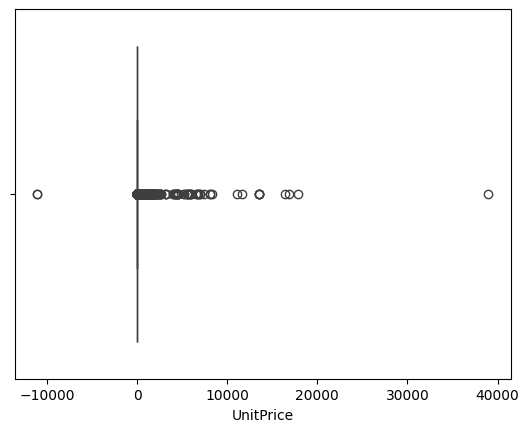

In [34]:
#Are there potential outliers in prices or quantities that may distort analysis? 

sns.boxplot(data=df, x='UnitPrice')
print('There are a lot of price outliers. Most prices (50% of items) are around 1,25-4,13. That is the vertical line on the plot')

df.UnitPrice.describe()

The amount of outliers is still to big to cleary display using the typical definition of Outlier. We will stick with a list


<Axes: xlabel='StockCode', ylabel='UnitPrice'>

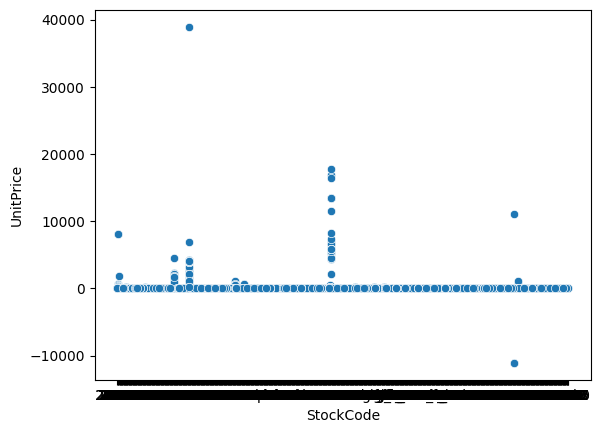

In [35]:
#'We will explore deeper on those outliers'
Q1 = df['UnitPrice'].quantile(0.25)
Q3 = df['UnitPrice'].quantile(0.75)
IQR = Q3 - Q1
outlier_upper = Q3 + 1.5*IQR
outlier_lower = Q1 - 1.5*IQR
print('The amount of outliers is still to big to cleary display using the typical definition of Outlier. We will stick with a list')
df_outlier_prices = df[(df.UnitPrice<outlier_lower)|(df.UnitPrice>outlier_upper)]
sns.scatterplot(data=df_outlier_prices, x='StockCode', y='UnitPrice') 

In [36]:
print('The following is a list with all the outliers in price from the list ')
print('We detect two instances of the product B with a negative price. This does not make sense. We will filter out') 
df_outlier_prices[df_outlier_prices['UnitPrice']>0][['StockCode','UnitPrice']].sort_values(by='UnitPrice').reset_index(drop=True)


The following is a list with all the outliers in price from the list 
We detect two instances of the product B with a negative price. This does not make sense. We will filter out


,StockCode,UnitPrice
0,21631,8.47
1,21632,8.47
2,21633,8.47
3,84968A,8.47
4,84968C,8.47
...,...,...
39443,AMAZONFEE,13541.33
39444,AMAZONFEE,16453.71
39445,AMAZONFEE,16888.02
39446,AMAZONFEE,17836.46


In [37]:
##We do the same with quantities
print('Here is a list of outlier products in terms of quantities sold and returned')
print('In this case we did not filter out products based on any other criteria')
Q1 = df['Quantity'].quantile(0.25)
Q3 = df['Quantity'].quantile(0.75)
IQR = Q3 - Q1
outlier_upper = Q3 + 1.5*IQR
outlier_lower = Q1 - 1.5*IQR
df_outlier_quantities = df[(df.Quantity<outlier_lower)|(df.Quantity>outlier_upper)]
df_outlier_quantities[['StockCode', 'Quantity']].sort_values(by='Quantity').reset_index(drop=True)

Here is a list of outlier products in terms of quantities sold and returned
In this case we did not filter out products based on any other criteria


,StockCode,Quantity
0,23843,-80995
1,23166,-74215
2,23005,-9600
3,23005,-9600
4,84347,-9360
...,...,...
58496,84077,4800
58497,37413,5568
58498,84826,12540
58499,23166,74215


There is strong presence of outliers in terms of UnitPrice and Quantity. We should be careful when drawing conclusions that are vulnerable to outliers, like mean calculations. Median and percentiles should be preferred.

# 6) Advanced Customer Insights

In [38]:
#Can we build an **RFM segmentation** (Recency, Frequency, Monetary) to profile customers?  
##We will create a table: Last Purchase Amount of Purchases and Total Revenue (RFM)
##We will assume that the current date is the last date of the invoice '2011-12-09 12:50:00'
print('The following is the RFM table for the customers of the ecommerce')
recency = (pd.to_datetime('2011-12-09 12:50:00') - df.groupby('CustomerID')['InvoiceDate'].max()).dt.days
frequency = df.groupby('CustomerID')['InvoiceDate'].nunique()
revenue = df.groupby('CustomerID')['Revenue'].sum() 
RFM = pd.DataFrame({'Recency':recency, 'Frequency':frequency,'Revenue':revenue})
RFM



The following is the RFM table for the customers of the ecommerce


,Recency,Frequency,Revenue
CustomerID,,,
12346.0,325,2,0.00
12347.0,1,7,4310.00
12348.0,74,4,1797.24
12349.0,18,1,1757.55
12350.0,309,1,334.40
...,...,...,...
18280.0,277,1,180.60
18281.0,180,1,80.82
18282.0,7,3,176.60


In [39]:
#What actionable recommendations can be drawn for marketing, operations, or product strategy based on this analysis?  

We will assume the following:
1) High frequency, high Recency, high Revenue => Champions. May not need to increase advertisement efforts
2) Low frequency, low recency, low revenue => Lost. Don't increase advertisement efforts
3) Low frequency, high recency, low revenue => New customers. May be good to increase advertisement efforts to hook them in
4) High frequency, low recency, high revenue => Risk users. Most important users to target to guide them back before lose them/

We will focus on the group 4.
We will durther define it:
- a) High frequency is top quartile of all users
- b) Low recency is more than **14 days. This should be reviewed depending on the specific business case.**
- c) High revenue is top quartile of all users


In [40]:
frequency_Q3 = RFM.Frequency.quantile(0.75)
revenue_Q3 = RFM.Revenue.quantile(0.75)
condition = (RFM.Frequency>frequency_Q3)&(RFM.Revenue>revenue_Q3)&(RFM.Recency>=14)
revenue_risk_users_rate = 100*RFM[condition]['Revenue'].sum()/RFM['Revenue'].sum()
print('The following is the table with all the risky customers that should be contacted to prevent loosing them, based on the criteria we defined before')
print(f'This is a small fraction of the total users, only {round(100*RFM[condition].shape[0]/RFM.shape[0],1)}%, account for {round(revenue_risk_users_rate,1)}% of total revenue that is very likely to be lost if left alone')
RFM[condition].sort_values(by='Revenue', ascending=False)

The following is the table with all the risky customers that should be contacted to prevent loosing them, based on the criteria we defined before
This is a small fraction of the total users, only 8.6%, account for 20.3% of total revenue that is very likely to be lost if left alone


,Recency,Frequency,Revenue
CustomerID,,,
12415.0,23,25,123725.45
16029.0,38,73,53168.69
16422.0,16,74,33805.69
12931.0,21,20,33462.81
14680.0,24,23,26932.34
...,...,...,...
15953.0,14,10,1632.43
13627.0,58,7,1624.02
13184.0,14,12,1616.45


In [41]:
##We will run a classification model to look for groups of customers to target together  
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler



In [42]:
##Setting up KMeans model
X = RFM[['Recency','Frequency','Revenue']].dropna()
Xscaled = StandardScaler().fit_transform(X)


We choose three clusters. After that point inertia drops more slowly


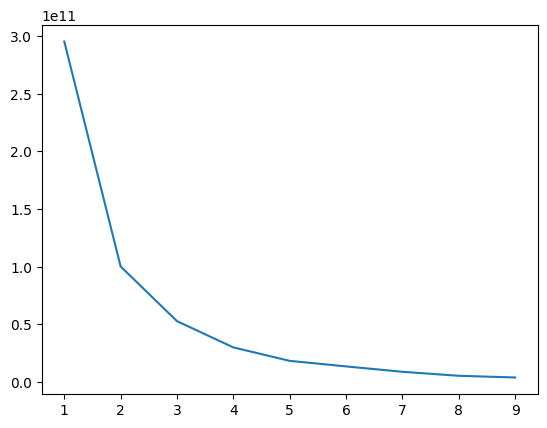

In [43]:
## We search for the best possible model. We select the best K parameter (lowest possible that minimizes inertia)
inertia = []
karray = []

def plot_inertia(x):
    for k in range(1,10):
        temp_model = KMeans(n_clusters=k).fit(x)
        inertia.append(temp_model.inertia_)
        karray.append(k)
    sns.lineplot(x=karray, y=inertia)
plot_inertia(X)
print('We choose three clusters. After that point inertia drops more slowly')

In [44]:
model = KMeans(n_clusters=3).fit(X)

In [45]:
RFM['Group'] = model.labels_


print('Renaming the groups given characteristics')
replace_dict = {0:'Unengaged users', 1:'Champion users', 2:'Engaged users' }
RFM.Group = RFM.Group.replace(replace_dict)
print(f'We identified 3 main groups \n{RFM['Group'].value_counts()}')

Renaming the groups given characteristics
We identified 3 main groups 
Group
Unengaged users    4338
Engaged users        29
Champion users        5
Name: count, dtype: int64


In [46]:
print(f'Group 1 is the smallest, with only 5 people')
#RFM[RFM['Group']==1]

Group 1 is the smallest, with only 5 people


In [47]:
print(f'Group 2 is very small, with only 29 people')
#RFM[RFM['Group']==2]

Group 2 is very small, with only 29 people


In [48]:
print(f'Group 0 is all the other people, 4338 people')
RFM[RFM['Group']==0]

Group 0 is all the other people, 4338 people


,Recency,Frequency,Revenue,Group
CustomerID,,,,


Here we are liking at TOTALS per group


np.float64(0.38)

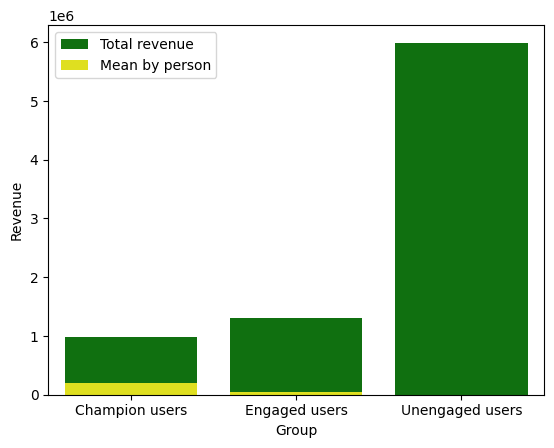

In [49]:
sns.barplot(data=RFM.groupby('Group')['Revenue'].sum().reset_index(), x='Group', y='Revenue', label='Total revenue', color='Green')
sns.barplot(data=RFM.groupby('Group')['Revenue'].mean().reset_index(), x='Group', y='Revenue', label='Mean by person', color='Yellow')
print('Here we are liking at TOTALS per group')
revenue_rate_champion_engaged = round(RFM[(RFM.Group=='Champion users') | (RFM.Group == 'Engaged users')]['Revenue'].sum()/RFM[(RFM.Group=='Unengaged users')].Revenue.sum(),2)
revenue_rate_champion_engaged # Percentage of the two groups over total

Here we are looking a the average person in each group


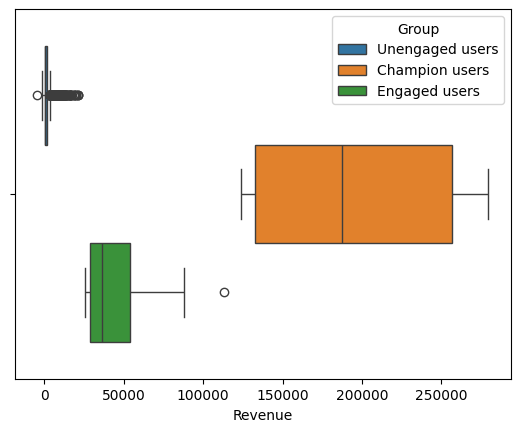

In [50]:
sns.boxplot(data=RFM, x='Revenue', hue='Group')
print('Here we are looking a the average person in each group')

<Axes: xlabel='Group', ylabel='Frequency'>

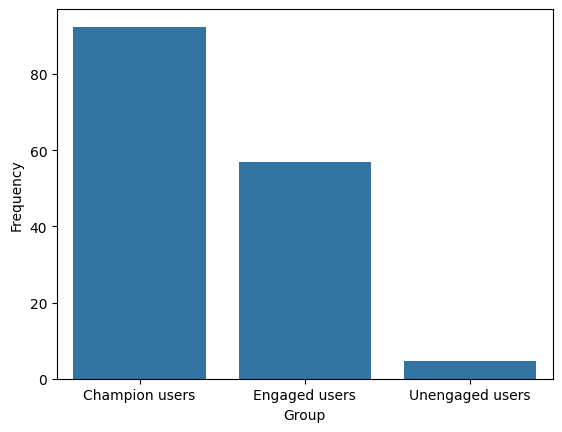

In [51]:
sns.barplot(data=RFM.groupby('Group')['Frequency'].mean().reset_index(), x='Group', y='Frequency')


<Axes: xlabel='Frequency'>

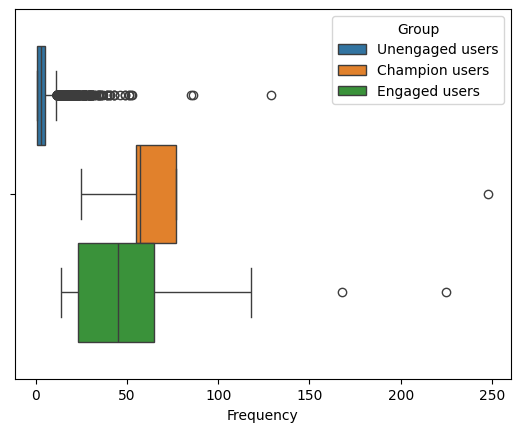

In [52]:
sns.boxplot(data=RFM, x='Frequency', hue='Group')

Text(0, 0.5, 'Recency [Days since last interation]')

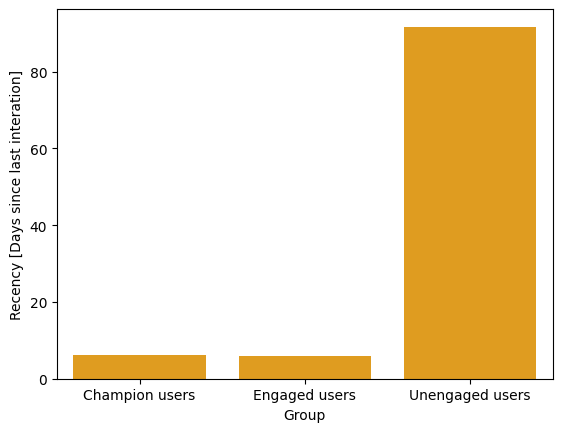

In [53]:
sns.barplot(data=RFM.groupby('Group')['Recency'].mean().reset_index(), x='Group', y='Recency', color='Orange')
plt.ylabel('Recency [Days since last interation]')

<Axes: xlabel='Recency'>

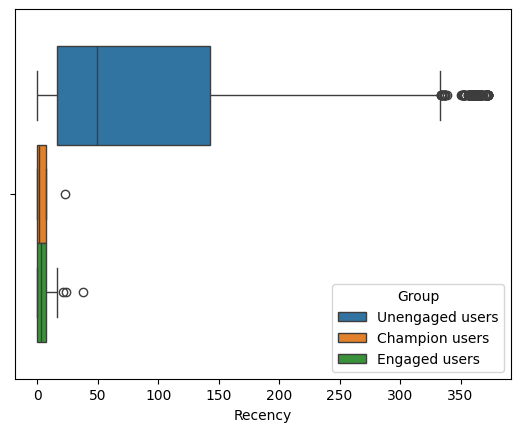

In [54]:
sns.boxplot(data=RFM, x='Recency', hue='Group')

In [55]:
RFM[RFM.Group=='Engaged users'].sort_values(by='Revenue',ascending=False).head(5)

,Recency,Frequency,Revenue,Group
CustomerID,,,,
14156.0,9,65,113214.59,Engaged users
17511.0,2,47,88125.38,Engaged users
16684.0,3,30,65892.08,Engaged users
13694.0,3,60,62690.54,Engaged users
15311.0,0,118,59284.19,Engaged users


# 7) Customer Retention and Lifetime Value (LTV)


In [57]:
#How many customers make repeat purchases?  
n_purchase_by_customer = df.groupby('CustomerID').size()
n_repeated_customers = (n_purchase_by_customer>1).sum()
n_customers = n_purchase_by_customer.count()
print(f'There are {n_customers} customers and {n_repeated_customers} bought at least twice, that is {round(100*n_repeated_customers/n_customers,1)}%')


There are 4372 customers and 4293 bought at least twice, that is 98.2%


In [ ]:
#How does new customer acquisition change over time?  
customer_first_invoice = df.groupby('CustomerID').InvoiceDate.min().dt.to_period('M').sort_values().reset_index().rename(columns={'InvoiceDate':'First_purchase'})
customer_acquisition = customer_first_invoice.First_purchase.value_counts().sort_index()
sns.barplot(y=customer_acquisition.values, x=customer_acquisition.index)
plt.xticks(rotation=45)
plt.ylabel('Amount of new customers')
print('Customer acquisition seem to go down and be lowest on August, and picks up in the following months. December 2011 is partially logged so should be ignored.')

In [ ]:
#What is the retention rate by monthly cohort (based on first purchase)?  
customer_first_invoice


In [ ]:
#How does average LTV vary across cohorts or countries?  


In [ ]:
#What patterns suggest churn or seasonal effects?  

# 8) Conclusion


### 📊 Data Quality Observations
- **25% of invoices** have **no CustomerID** → tracking must be improved to enhance behavioral analysis.  
  *(High impact on customer segmentation accuracy.)*
- **Duplicated invoices** ≈ **1% (≈5,000 records)**  
- **Negative Unit Prices** ≈ **0.4% (≈2,500 records)**  
- **Missing Descriptions** ≈ **1% (≈5,000 records)**  

Improving the invoicing system to prevent these inconsistencies would boost data reliability.  
These are low-effort, high-payoff (“low hanging fruit”) data-quality fixes.

---

### 💰 Pricing Insight
> A small increase in unit price for the **most sold items**, especially those **not among the highest revenue generators**, would likely have the **largest impact on total revenue**.

---

### 🏷️ Top 10 Most Sold Items
| StockCode | Description | Quantity |
|------------|--------------|-----------|
| 84077 | WORLD WAR 2 GLIDERS ASSTD DESIGNS | 53,751 |
| 85099B | JUMBO BAG RED RETROSPOT | 47,260 |
| 22197 | POPCORN HOLDER | 36,322 |
| 84879 | ASSORTED COLOUR BIRD ORNAMENT | 36,282 |
| 21212 | PACK OF 72 RETROSPOT CAKE CASES | 36,016 |
| 85123A | WHITE HANGING HEART T-LIGHT HOLDER | 35,006 |
| 23084 | RABBIT NIGHT LIGHT | 30,631 |
| 22492 | MINI PAINT SET VINTAGE | 26,437 |
| 22616 | PACK OF 12 LONDON TISSUES | 26,299 |
| 21977 | PACK OF 60 PINK PAISLEY CAKE CASES | 24,719 |

---

### 💸 Top 10 Items by Revenue
| StockCode | Description | Revenue (£) |
|------------|--------------|--------------|
| DOT | DOTCOM POSTAGE | 206,245.48 |
| 22423 | REGENCY CAKESTAND 3 TIER | 164,459.49 |
| 47566 | PARTY BUNTING | 98,243.88 |
| 85123A | WHITE HANGING HEART T-LIGHT HOLDER | 97,659.94 |
| 85099B | JUMBO BAG RED RETROSPOT | 92,175.79 |
| 23084 | RABBIT NIGHT LIGHT | 66,661.63 |
| POST | POSTAGE | 66,230.64 |
| 22086 | PAPER CHAIN KIT 50'S CHRISTMAS | 63,715.24 |
| 84879 | ASSORTED COLOUR BIRD ORNAMENT | 58,792.42 |
| 79321 | CHILLI LIGHTS | 53,746.66 |


### 🌍 Revenue Distribution by Country
**The UK** represents **84%** of the total revenue.  
Marketing and customer support efforts should be primarily focused there.

---

### 👥 Customer Concentration
Revenue is spread across **4,372 customers**.  
The **top customer** contributes **2.87%** of total revenue — indicating the business is **not dependent on a few large clients**, which makes it more stable.

#### Customers with ≥1% of Total Revenue
| CustomerID | % Total Revenue |
|-------------|----------------|
| 14646.0 | 2.87% |
| 18102.0 | 2.64% |
| 17450.0 | 1.93% |
| 14911.0 | 1.36% |
| 12415.0 | 1.27% |
| 14156.0 | 1.16% |

The **top 5% of customers (218 users)** account for **41.4% of total revenue**.  
Keeping them satisfied is key for revenue sustainability, and upselling to them is likely the easiest growth path.  
*(The top 34 users alone generate 38% of total revenue.)*

---

### 📅 Time Analysis
With only one year of data, yearly patterns cannot be confirmed.  
The best months of 2011 are:

| Month | Revenue |
|--------|----------|
| 2011-11 | 1,456,145.80 |
| 2011-10 | 1,069,368.23 |
| 2011-09 | 1,017,596.68 |

There is also unusually high activity on specific dates and hours:

| DateTime | Revenue |
|-----------|----------|
| 2011-11-07 17:00 | 54,089.63 |
| 2011-11-14 17:00 | 51,884.23 |

---

### 🚚 Top Customers by Purchase Volume
Some clients purchase very large quantities — improving **logistics planning** around them could reduce costs.

| CustomerID | # Items |
|-------------|----------|
| 17841.0 | 7,812 |
| 14911.0 | 5,898 |
| 14096.0 | 5,128 |

---

### 🔁 Items with High Return Rates
Certain products have unusually high return ratios (≥10 purchases only):

| StockCode | Return Rate (%) | Amount Purchased |
|------------|----------------|-----------------|
| 35610C | 44.8 | 25 |
| 22618 | 24.7 | 69 |
| 35610B | 22.5 | 24 |
| 23116 | 18.9 | 76 |
| 84809B | 18.0 | 18 |

*Some items (e.g. 23843) were purchased and cancelled quickly, so they were excluded.*

---

### 🧩 RFM Segmentation (K-Means Clustering)
Three user categories were identified:

- **Champions** (5 users)  
- **Engaged** (29 users)  
- **Unengaged** (≈99% of users)

Groups **a + b** together generate **38% of total revenue** — crucial for retention and upselling strategies.

#### 🏆 Champion Users
| CustomerID | Recency | Frequency | Revenue |
|-------------|----------|-----------|----------|
| 12415.0 | 23 | 25 | 123,725.45 |
| 14646.0 | 1 | 77 | 279,489.02 |
| 14911.0 | 0 | 248 | 132,458.73 |
| 17450.0 | 7 | 55 | 187,322.17 |
| 18102.0 | 0 | 57 | 256,438.49 |

#### 💼 Engaged Users (Top 5 by Revenue)
| CustomerID | Recency | Frequency | Revenue |
|-------------|----------|-----------|----------|
| 14156.0 | 9 | 65 | 113,214.59 |
| 17511.0 | 2 | 47 | 88,125.38 |
| 16684.0 | 3 | 30 | 65,892.08 |
| 13694.0 | 3 | 60 | 62,690.54 |
| 15311.0 | 0 | 118 | 59,284.19 |

#### 😴 Unengaged Users (Top 5)
| CustomerID | Recency | Frequency | Revenue |
|-------------|----------|-----------|----------|
| 15749.0 | 234 | 4 | 21,535.90 |
| 16210.0 | 1 | 18 | 21,086.30 |
| 12753.0 | 3 | 11 | 21,024.01 |
| 17381.0 | 8 | 30 | 20,272.43 |
| 17675.0 | 0 | 41 | 20,098.10 |
